In [2]:
import sys
sys.path.append('../..')
import numpy as np
import pandas as pd
from pathlib import Path
from model_utils import split_samples, split_periods
from neuralhydrology.utils.config import Config
import xarray as xr
from tqdm.auto import tqdm
import pickle

In [3]:
import matplotlib.pyplot as plt

In [62]:
import cartopy.crs as ccrs
import cartopy.feature as cfeature

## Configuración

In [50]:
TRAIN_SIZE = .7
VAL_SIZE = .3

In [7]:
# cargar archivo de configuración
config_file = Path('config.yml')
cfg = Config(config_file)

target = cfg.target_variables[0]

print(cfg.experiment_name)
print('epochs:', cfg.epochs, sep='\t\t')
print('hidden size:', cfg.hidden_size, sep='\t')
print('batch size:', cfg.batch_size, sep='\t')
print('dropout:', cfg.output_dropout, sep='\t')
print('clip gradients:', cfg.clip_gradient_norm, sep='\t')

reservoir_lstm_HP
epochs:		10
hidden size:	64
batch size:	128
dropout:	0.3
clip gradients:	1


## Samples 

In [85]:
# load attribute table
attrs = pd.read_csv(cfg.data_dir / 'attributes' / 'attributes_combined.csv', index_col='reservoir_id')
print('Reservoirs in the original attribute table:\t{0}'.format(attrs.shape[0]))

# load reservoir use table
use = pd.read_csv(cfg.data_dir / 'attributes' / 'attributes_use.csv', index_col='reservoir_id')
print('Reservoirs in the original use table:\t\t{0}'.format(use.shape[0]))

# select single-use, hydropower reservoirs
single_use = use.sum(axis=1) == 1
hydropower = use.hydropower == 1
attrs_sel = attrs.loc[hydropower & single_use]
print('Single-use hydopower reservoirs:\t\t{0}'.format(attrs_sel.shape[0]))

# divide sample in calibration, validation and test subsets
path = cfg.train_basin_file.parent
path.mkdir(exist_ok=True)
samples = split_samples(attrs_sel.index.tolist(), cal=TRAIN_SIZE, val=VAL_SIZE, seed=0)#, path=path)

# export or put out
if path is not None:
    for key, ls in samples.items():
        with open(path / f'sample_{key}.txt', 'w') as file:
            file.writelines(f"{id}\n" for id in ls)

Reservoirs in the original attribute table:	290
Reservoirs in the original use table:		290
Single-use hydopower reservoirs:		28


In [88]:
attrs_sel.loc[samples['train'], 'LON']

reservoir_id
84     -6.685786
255    -7.167158
259    -6.304152
593    -6.187225
603     0.854115
611    -7.539997
647    -7.386541
741    -0.918338
1091   -6.142271
1197   -6.885102
1455   -7.218344
1485   -0.928137
1494   -0.851406
1767   -7.209227
1907   -5.985433
2076   -7.063980
2111   -6.804020
2126   -7.251221
2281   -5.991859
2483   -6.084844
Name: LON, dtype: float64

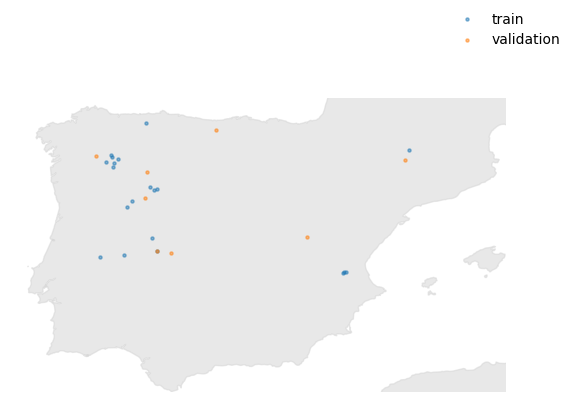

In [101]:
# plot reservoir locations
fig, ax = plt.subplots(subplot_kw=dict(projection=ccrs.PlateCarree()))
ax.add_feature(cfeature.NaturalEarthFeature('physical', 'land', '10m', edgecolor='face', facecolor='lightgray'),
               alpha=.5,
               zorder=0)
for sample, ids in samples.items():
    ax.scatter(attrs_sel.loc[ids, 'LON'], attrs_sel.loc[ids, 'LAT'], s=5, alpha=.5, label=sample)
ax.set_aspect('equal')
ax.set_extent([-10, 3.5, 36, 44])
fig.legend(frameon=False)
ax.axis('off');

## Periods

In [163]:
from typing import Optional, Union

def plot_timeseries(df: pd.DataFrame, storage: str, inflow: str, outflow: str, save: Optional[Union[str, Path]] = None, **kwargs):
    """
    """
    
    figsize = kwargs.get('figsize', (12, 4))
    lw = kwargs.get('lw', .8)
    title = kwargs.get('title', None)
    ylim = kwargs.get('ylim', (-.1, None))
    ylabel= kwargs.get('ylabel', None)
    colors = ['dimgray', 'steelblue', 'indianred']
    cols = {'storage': storage, 'inflow': inflow, 'outflow': outflow}

    fig, ax = plt.subplots(figsize=(12, 4))
    for (label, col), c in zip(cols.items(), colors):
        ax.plot(df.index, df[col], lw=lw, c=c, label=label)

    ax.set(xlim=(df.index.min(), df.index.max()),
           ylim=ylim,
           ylabel=ylabel,
           title=title)
    fig.legend(ncols=1, frameon=False, loc=5);
    
    if save is not None:
        plt.savefig(save, dpi=300, bbox_inches='tight')

In [164]:
path_plots = Path('./data/plots')
path_plots.mkdir(parents=True, exist_ok=True)

  0%|          | 0/28 [00:00<?, ?it/s]

/tmp/ipykernel_1195/1553531608.py:15: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, ax = plt.subplots(figsize=(12, 4))


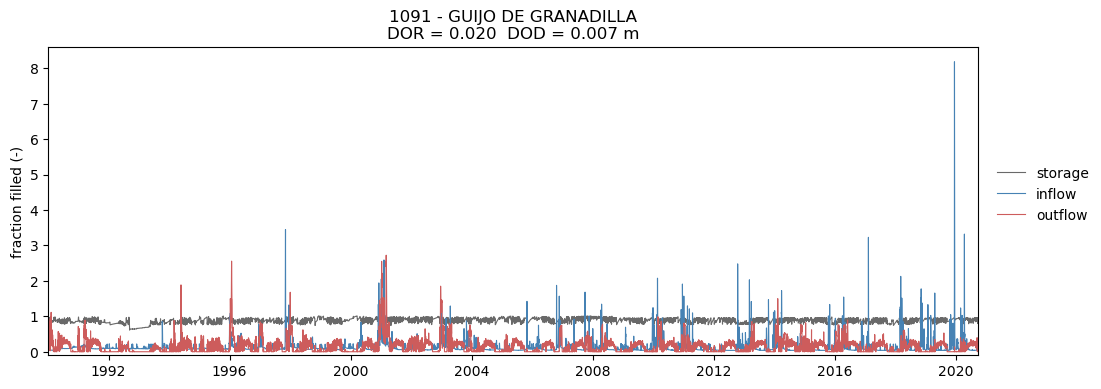

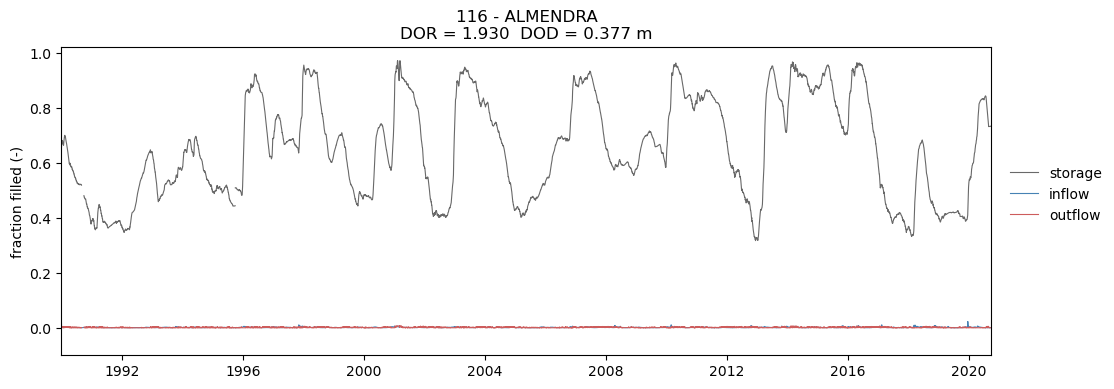

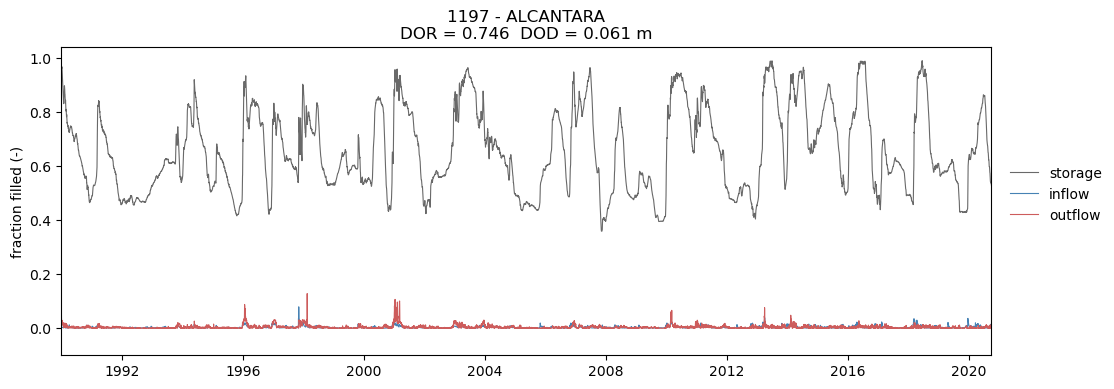

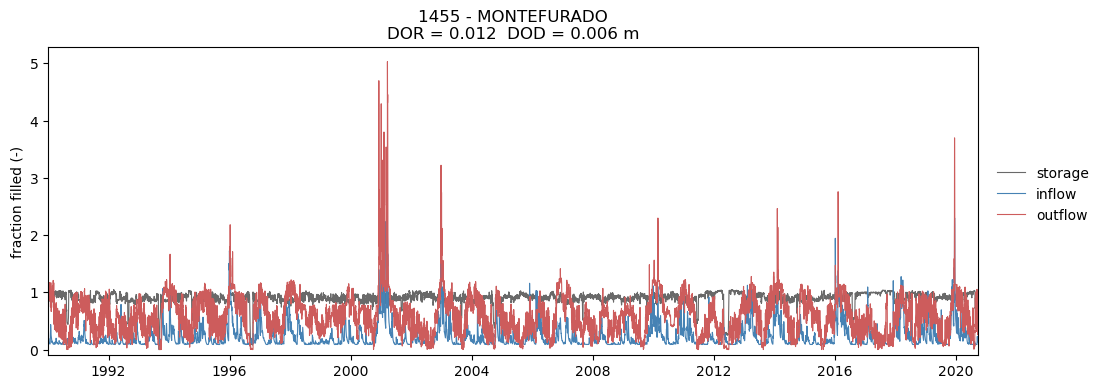

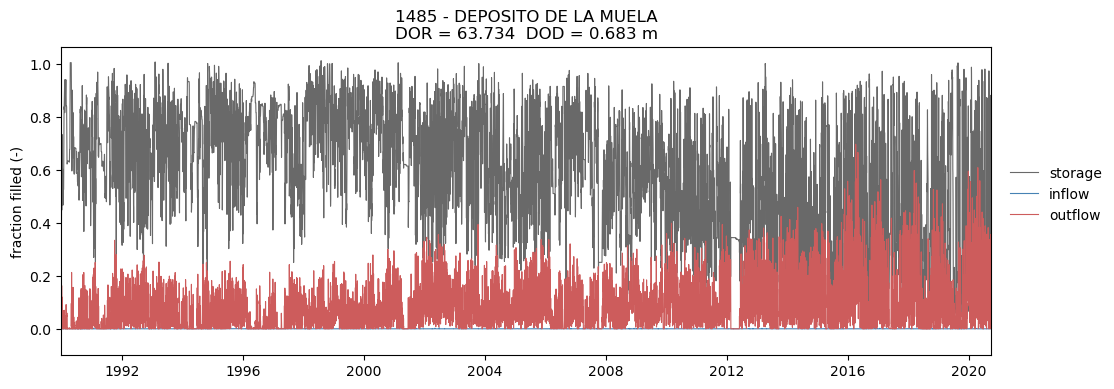

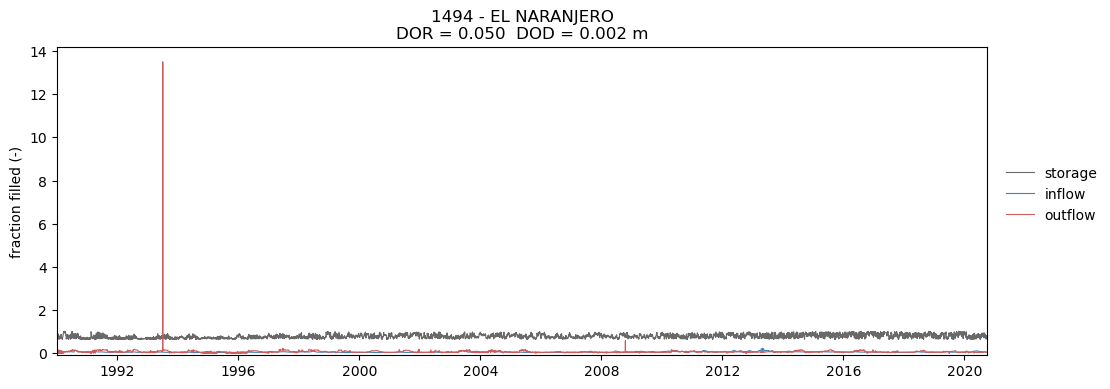

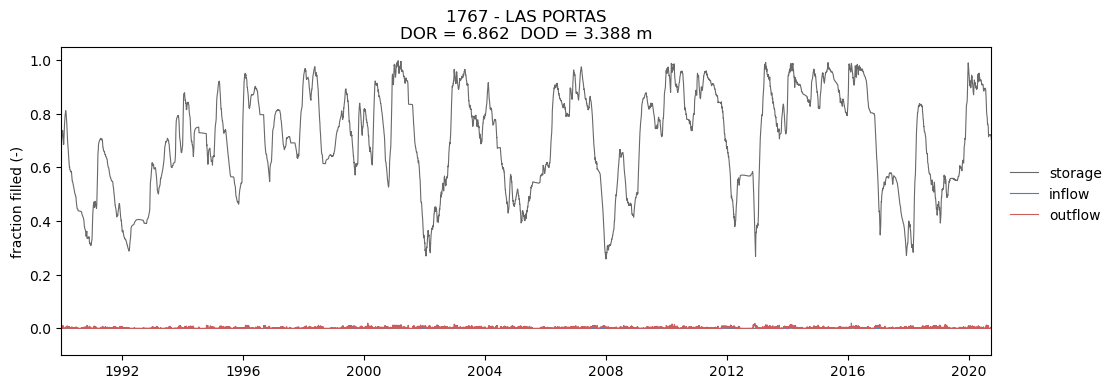

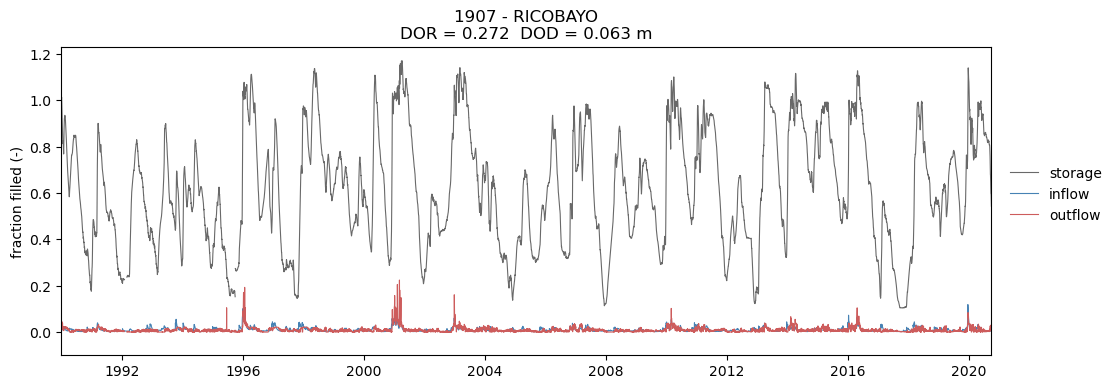

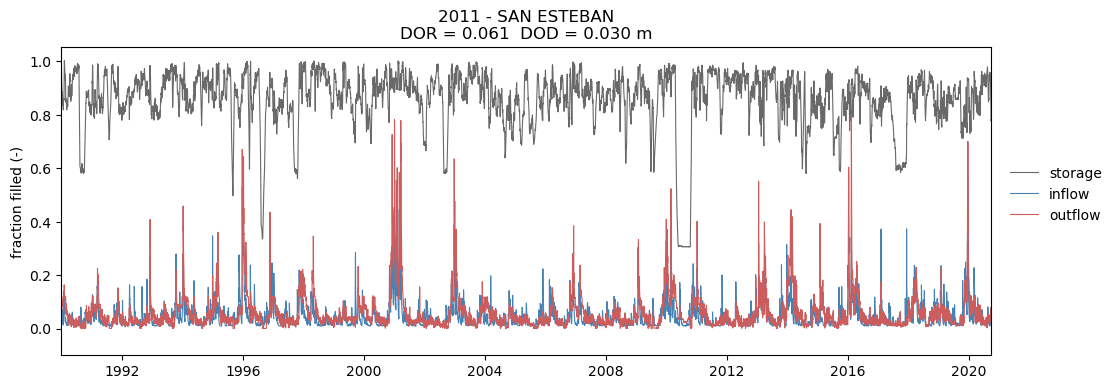

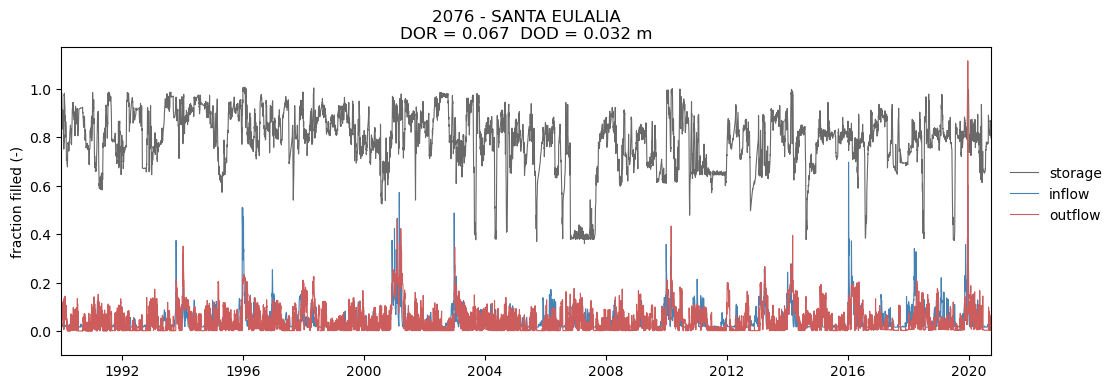

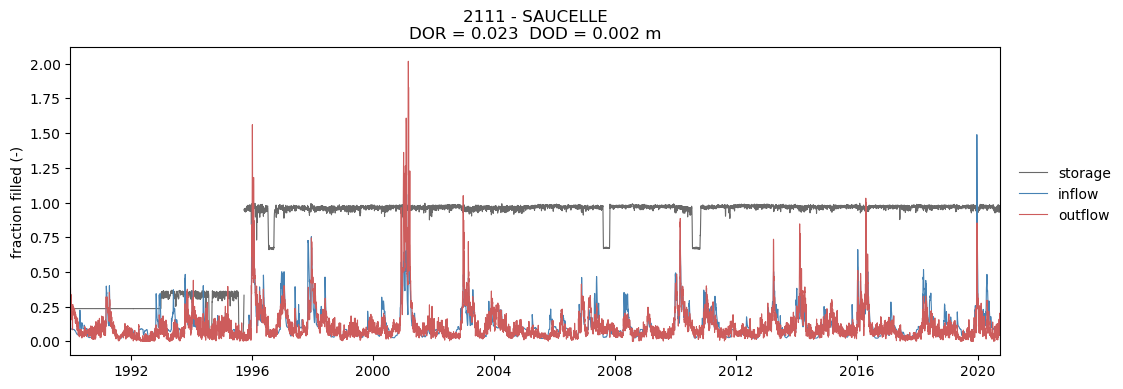

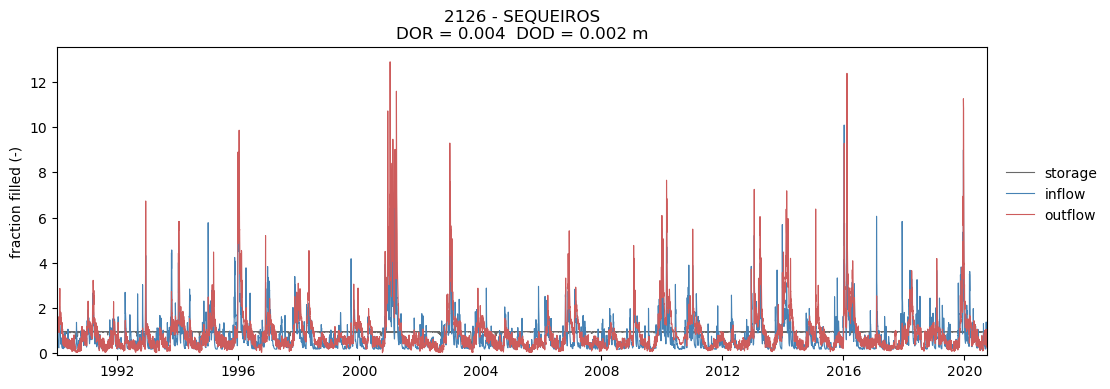

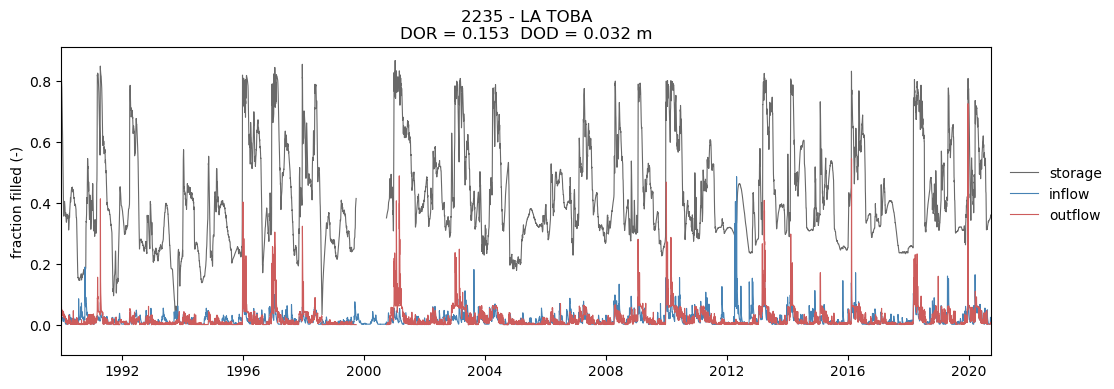

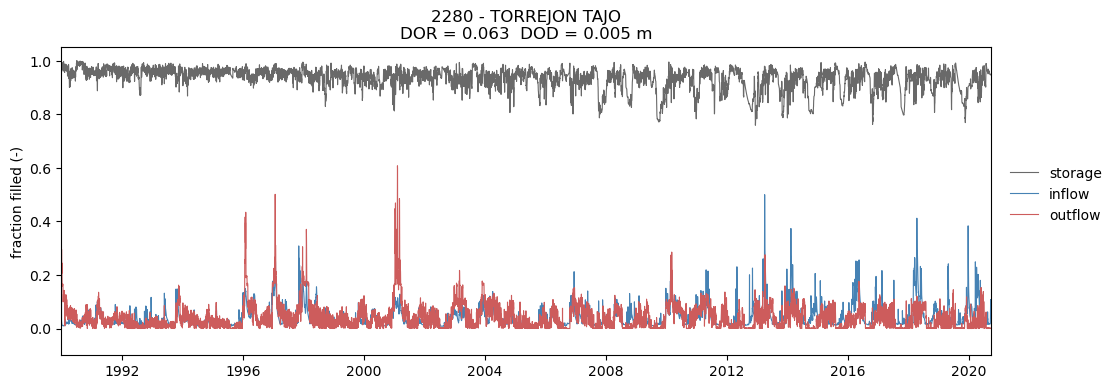

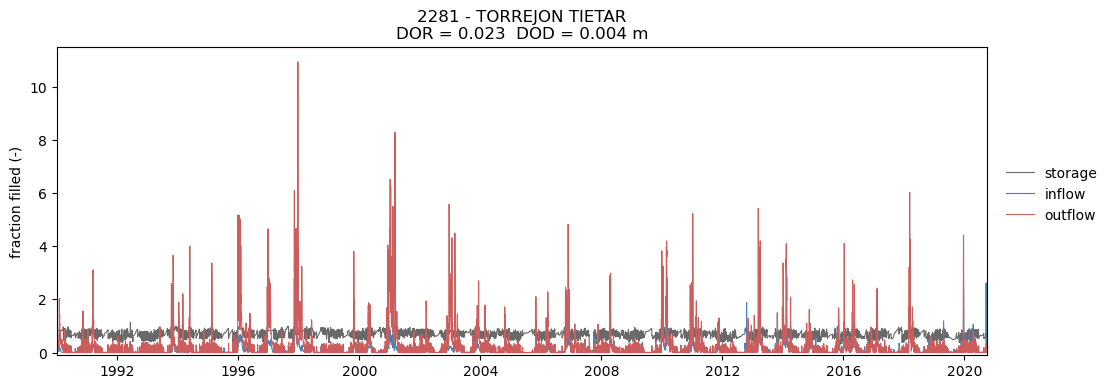

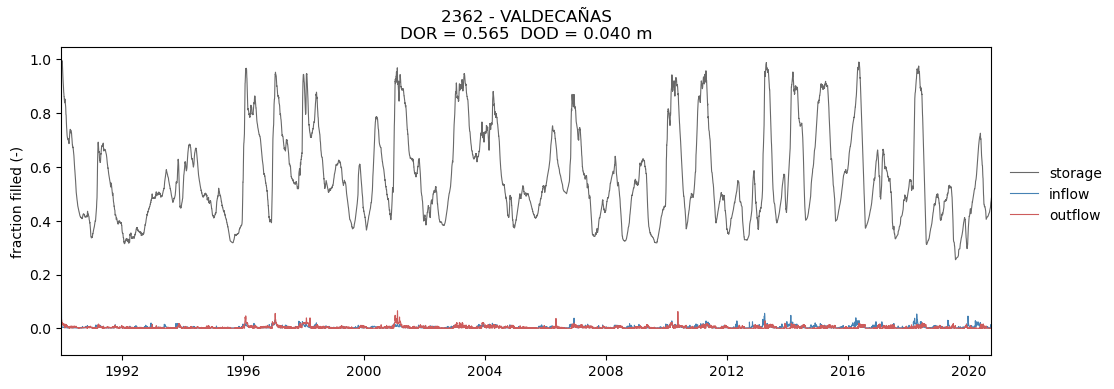

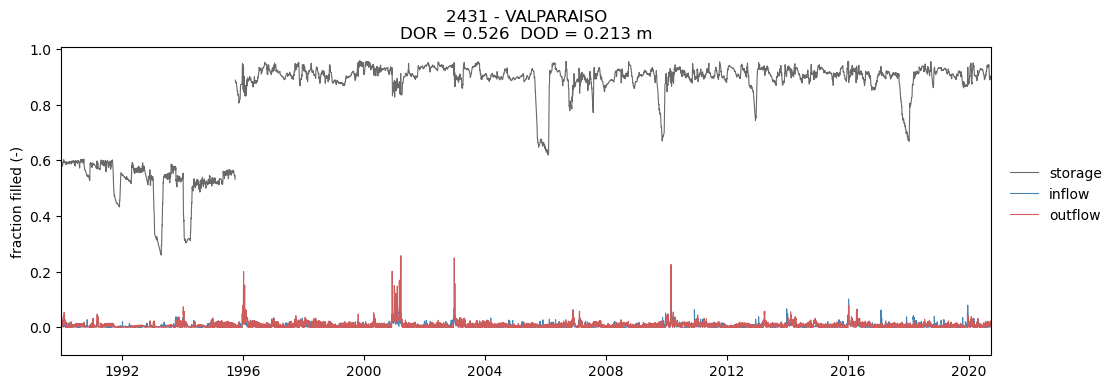

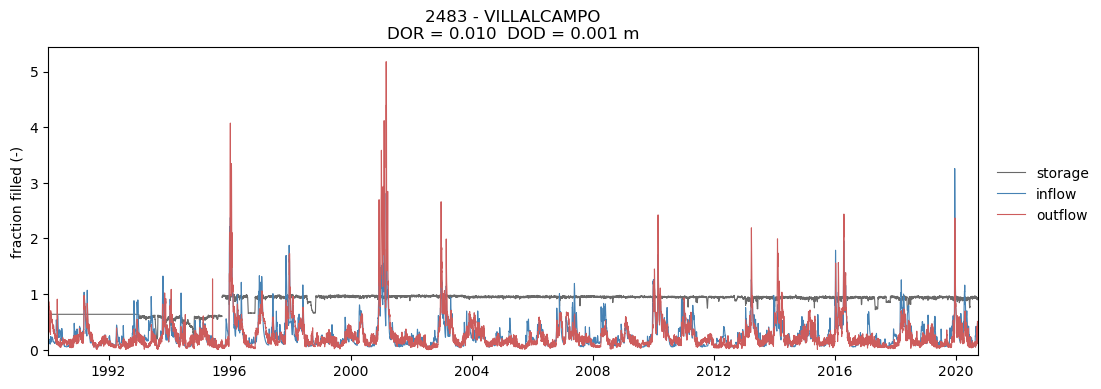

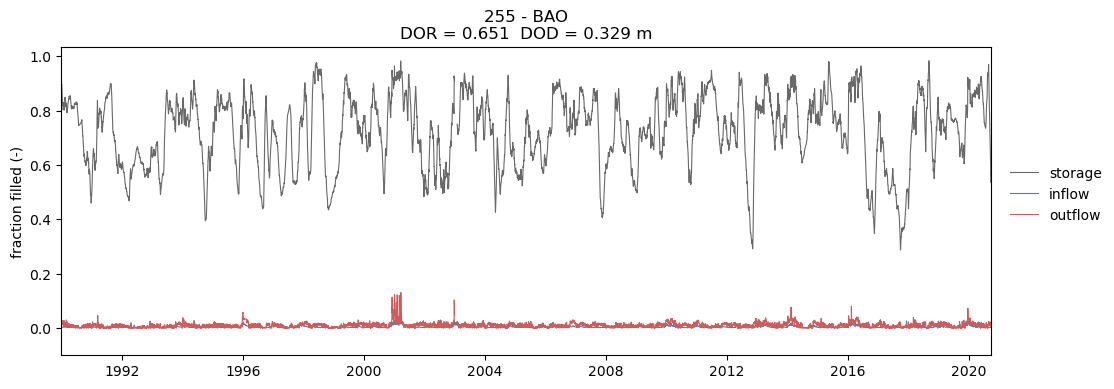

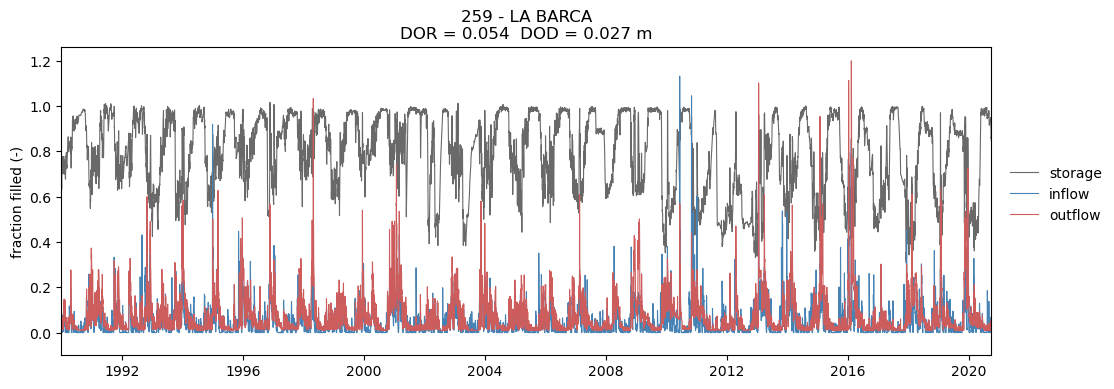

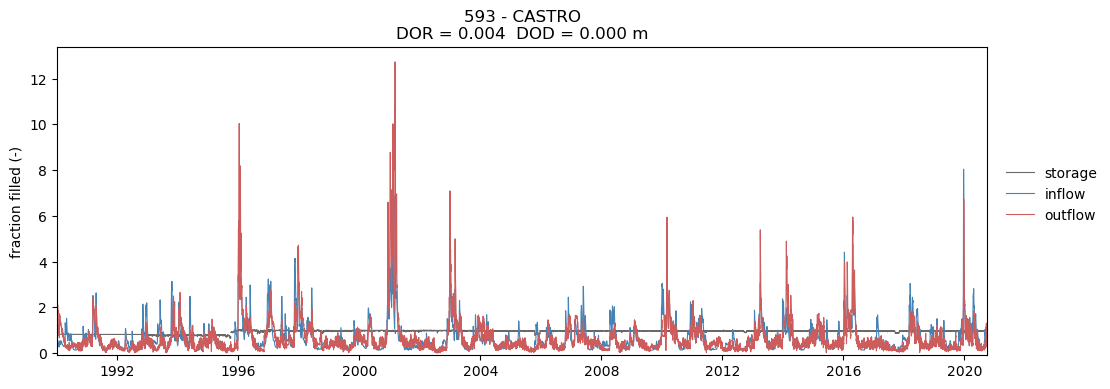

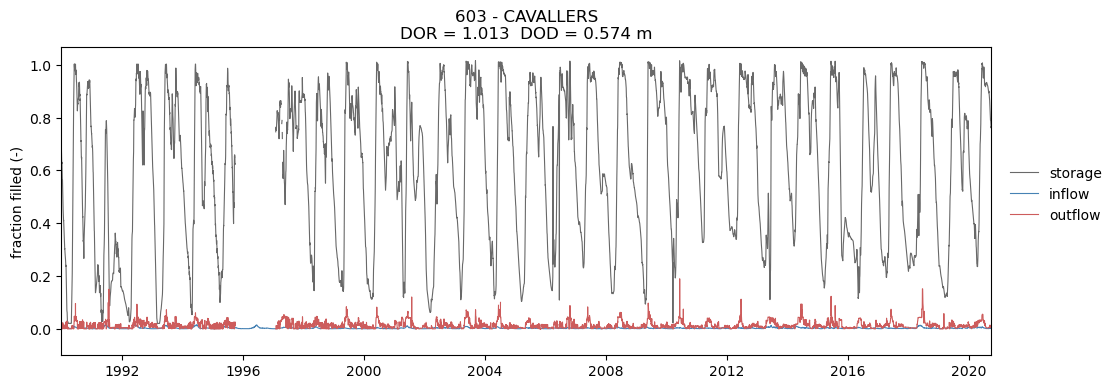

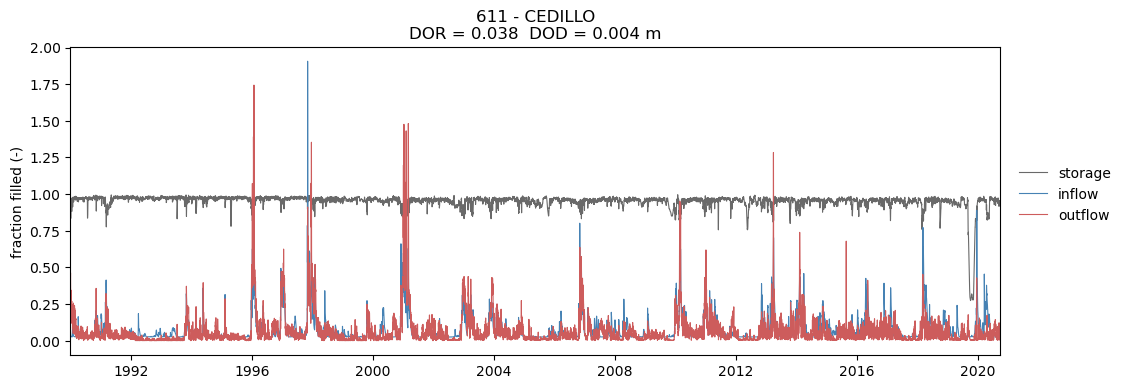

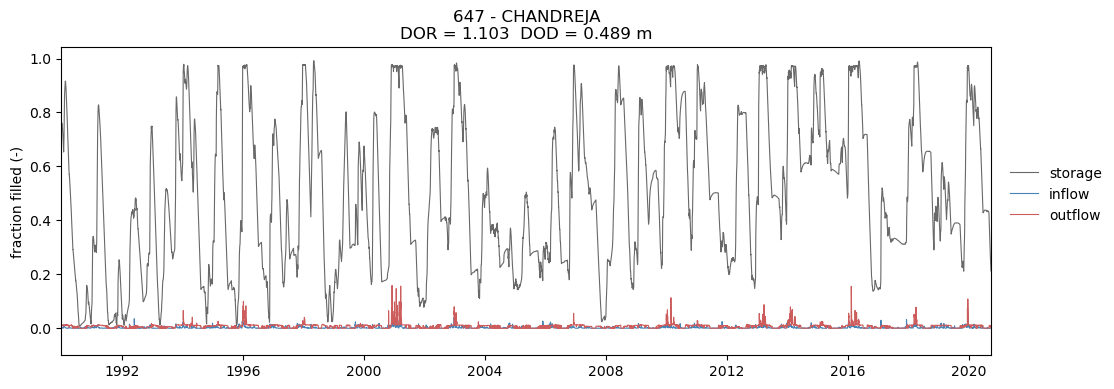

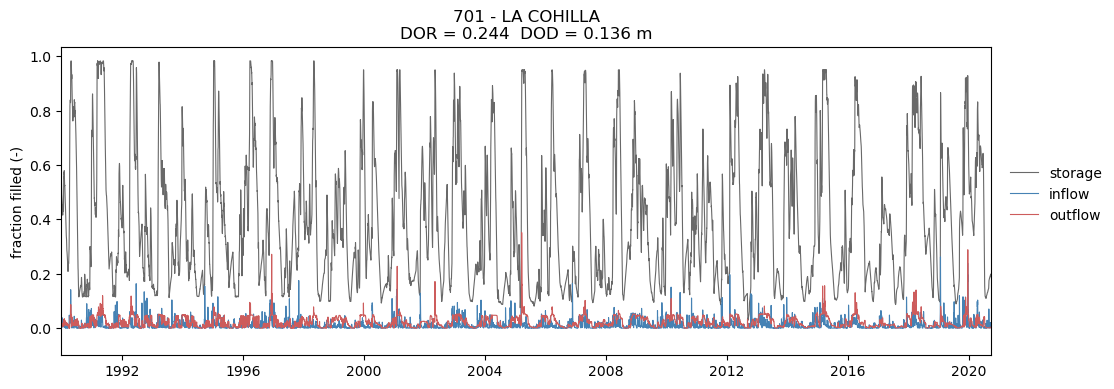

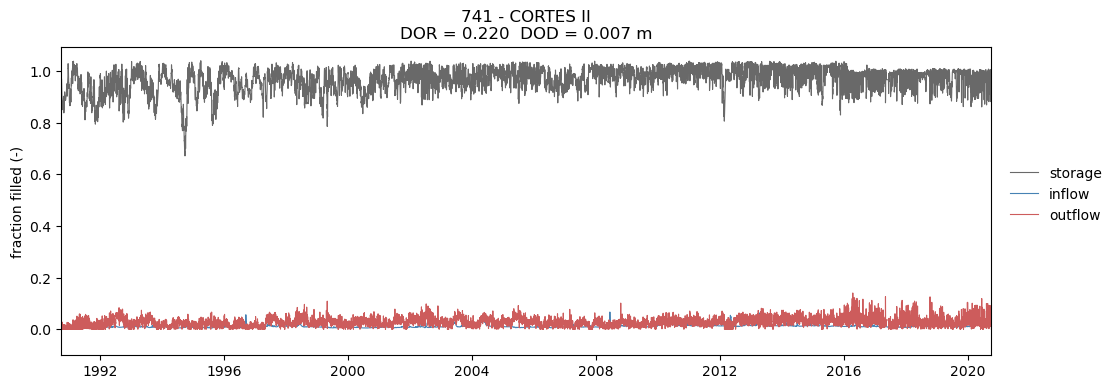

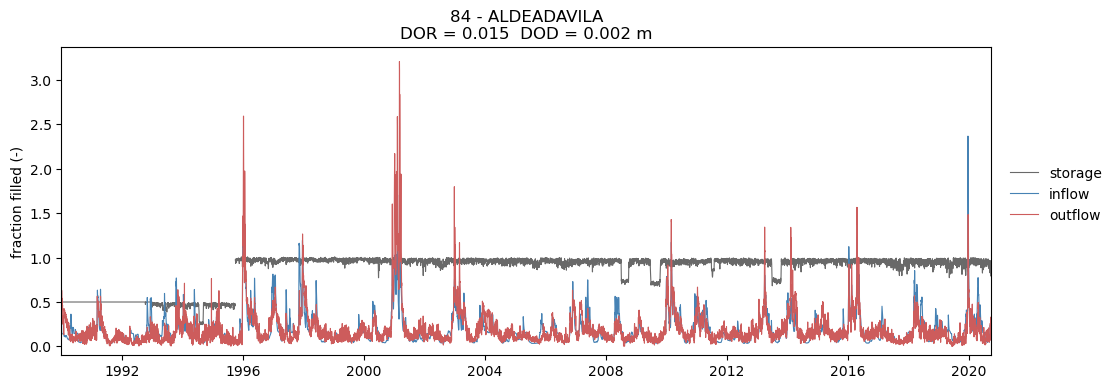

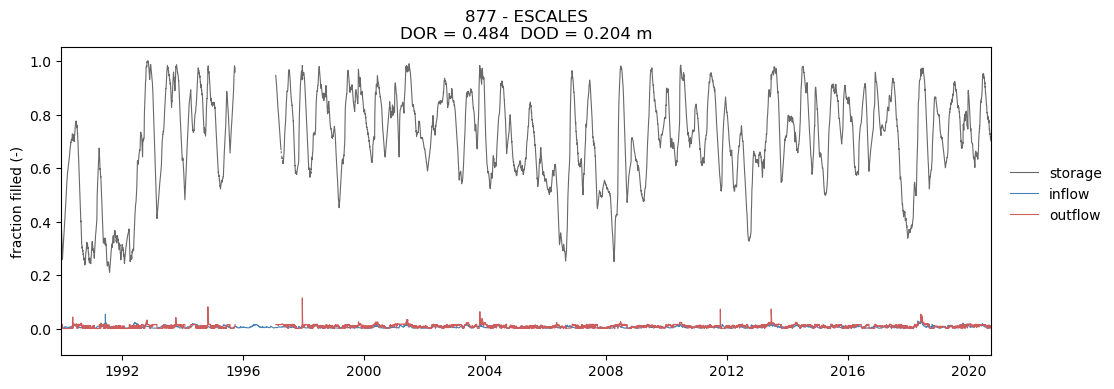

In [166]:
# define train, validation and test periods
periods = {}
for ID in tqdm(attrs_sel.index):
    file = cfg.data_dir / 'time_series' / f'{ID}.nc'
    if file.is_file():
        df = xr.open_dataset(file).to_pandas()#[cfg.target_variables].to_pandas()
        title = '{0} - {1}\nDOR = {2:.3f}  DOD = {3:.3f} m'.format(ID, *attrs.loc[ID, ['RES_NAME', 'DOR', 'DOD_M']])
        plot_timeseries(df, 'volume', 'inflow_efas5', 'outflow', ylabel='fraction filled (-)', title=title,
                        save=path_plots / f'{ID}.jpg')
        if ID in samples['train']:
            periods[file.stem] = split_periods(df, cal=1, val=0)
        elif ID in samples['validation']:
            periods[file.stem] = split_periods(df, cal=0, val=1)
    else:
        print(f'{file} was not found')

In [192]:
title

'877 - ESCALES\nDOR = 0.484  DOD = 0.204 m'

In [195]:
import numpy as np

In [197]:
from metrics import KGE

In [196]:
np.corrcoef(df.inflow_efas5, df.outflow)

array([[ 1., nan],
       [nan, nan]])

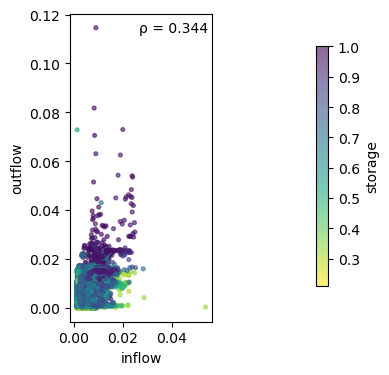

In [205]:
fig, ax = plt.subplots(figsize=(4, 4))

sct = ax.scatter(df.inflow_efas5, df.outflow, c=df.volume, marker='.', s=30, alpha=.6, cmap='viridis_r')
r = KGE(df.inflow_efas5, df.outflow)[3]
ax.text(.975, .975, f'ρ = {r:.3}', va='top', ha='right', transform=ax.transAxes)
cax = fig.add_axes([0.95, 0.2, 0.03, 0.6])  # Define the position of the new axes
fig.colorbar(sct, cax=cax, label='storage')
ax.set_xlabel('inflow')
ax.set_ylabel('outflow')
ax.set_aspect('equal', adjustable='box')
plt.show()

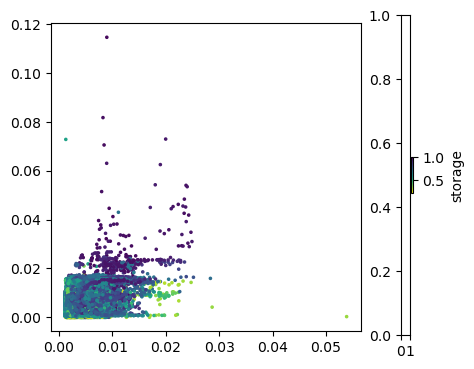

In [184]:
fig, ax = plt.subplots(figsize=(4, 4))

sct = ax.scatter(df.inflow_efas5, df.outflow, c=df.volume, marker='.', s=10, cmap='viridis_r')
cax = fig.add_axes([1.0, 0.1, 0.03, 0.8])
plt.colorbar(sct, ax=cax, label='storage')

In [111]:
periods_da = xr.concat([da.assign_coords(id=ID) for ID, da in periods.items()], dim='id')

# make sure there's 1 year of data before the start date
cutoff_date = np.datetime64('1992-01-02', 'ns')
periods_da = periods_da.where(periods_da >= cutoff_date, other=cutoff_date)
del periods

# reorganize periods as a dictionary
periods_dct = {}
for period in periods_da.period.data:
    periods_dct[period] = {}
    for ID in periods_da.id.data:
        periods_dct[period][ID] = {}
        for date in periods_da.date.data:
            periods_dct[period][ID][f'{date}_dates'] = [pd.Timestamp(periods_da.sel(period=period, id=ID, date=date).to_numpy().item())]

# export as Pickle
for period, dct in periods_dct.items():
    with open(f'./data/periods_{period}.pkl', 'wb') as file:
        pickle.dump(dct, file)

  0%|          | 0/28 [00:00<?, ?it/s]

ValueError: must supply at least one object to concatenate

In [110]:
df

,volume,lat,lon
date,,,
1990-01-01,0.375730,42.341667,0.741667
1990-01-02,0.370388,42.341667,0.741667
1990-01-03,0.363526,42.341667,0.741667
1990-01-04,0.354579,42.341667,0.741667
1990-01-05,0.348105,42.341667,0.741667
...,...,...,...
2020-09-26,0.703638,42.341667,0.741667
2020-09-27,0.704053,42.341667,0.741667
2020-09-28,0.706664,42.341667,0.741667


***

In [49]:
min_date = pd.Timestamp(1900, 1, 1)
max_date = pd.Timestamp(2100, 1, 1)
for period, ids_dct in periods_dct.items():
    for ID, dates_dct in ids_dct.items():
        min_date = max(min_date, dates_dct['start_dates'][0])
        max_date = min(max_date, dates_dct['end_dates'][0])

In [50]:
min_date, max_date

(Timestamp('2015-04-29 00:00:00'), Timestamp('1993-05-08 00:00:00'))

In [57]:
min_date = pd.Timestamp(1900, 1, 1)
max_date = pd.Timestamp(2100, 1, 1)
for id in periods_da.id.data:
    min_date = max(min_date, periods_da.sel(id=id).min().to_numpy())
    max_date = min(max_date, periods_da.sel(id=id).max().to_numpy())
min_date, max_date

(array('2011-09-13T00:00:00.000000000', dtype='datetime64[ns]'),
 array('2006-09-30T00:00:00.000000000', dtype='datetime64[ns]'))

In [93]:
periods_da.sel(id='2511').to_pandas()

period,train,validation,test
date,,,
start,2007-11-19,2002-06-11,1997-01-01
end,2024-03-12,2007-11-18,2002-06-10


In [81]:
periods_da.sel(id=2511).to_pandas()

period,train,validation,test
date,,,
start,2007-11-19,2002-06-11,1997-01-01
end,2024-03-12,2007-11-18,2002-06-10


In [82]:
periods_da.sel(id=2536).to_pandas()

period,train,validation,test
date,,,
start,2002-04-22,1996-02-26,1992-01-02
end,2020-09-30,2002-04-21,1996-02-25


***

In [67]:
PATH_RESOPS = Path('./data/ResOpsES')

In [68]:
ID = 2511

In [71]:
cfg.dynamic_inputs

['inflow_efas5', 'evaporation_emo1']

In [72]:
cfg.target_variables

['volume']

In [84]:
with open('./data/periods_train.pkl', 'rb') as file:
    periods_train = pickle.load(file)

In [85]:
periods_train

{10: {'start_dates': [Timestamp('2003-09-13 00:00:00')],
  'end_dates': [Timestamp('2020-09-30 00:00:00')]},
 1019: {'start_dates': [Timestamp('2002-04-22 00:00:00')],
  'end_dates': [Timestamp('2020-10-01 00:00:00')]},
 1026: {'start_dates': [Timestamp('2002-04-22 00:00:00')],
  'end_dates': [Timestamp('2020-10-01 00:00:00')]},
 1033: {'start_dates': [Timestamp('2006-08-09 00:00:00')],
  'end_dates': [Timestamp('2020-10-01 00:00:00')]},
 1038: {'start_dates': [Timestamp('2002-04-22 00:00:00')],
  'end_dates': [Timestamp('2020-09-30 00:00:00')]},
 1047: {'start_dates': [Timestamp('2002-04-22 00:00:00')],
  'end_dates': [Timestamp('2020-09-30 00:00:00')]},
 1062: {'start_dates': [Timestamp('2009-07-14 00:00:00')],
  'end_dates': [Timestamp('2024-03-12 00:00:00')]},
 1064: {'start_dates': [Timestamp('2002-04-22 00:00:00')],
  'end_dates': [Timestamp('2020-10-01 00:00:00')]},
 1065: {'start_dates': [Timestamp('2002-04-22 00:00:00')],
  'end_dates': [Timestamp('2020-09-30 00:00:00')]},
 10

In [ ]:
period = 'validation'

sample_train = pd.read_csv(f'./data/sample_{period}.txt', header=None).squeeze().tolist()

PATH_PLOT = PATH_RESOPS / 'time_series' / 'plots' / period
PATH_PLOT.mkdir(parents=True, exist_ok=True)

for ID in tqdm(sample_train):
    df = xr.open_dataset(PATH_RESOPS / 'time_series' / f'{ID}.nc').to_pandas()
    df = df[cfg.dynamic_inputs + cfg.target_variables]

    fig, ax = plt.subplots(figsize=(12, 4))
    df.plot(ax=ax, lw=1)
    ax.set(title=ID,
           xlim=(df.index.min(), df.index.max()));
    for x in periods_da.sel(id=str(ID), date='start').to_numpy():
        plt.axvline(x, ls='-', lw=.5, color='k', zorder=0)
    plt.savefig(PATH_PLOT / f'{ID}.jpg', dpi=300, bbox_inches='tight')

***

In [94]:
from neuralhydrology.datasetzoo import BaseDataset

In [96]:
BaseDataset(cfg, is_train=True, period='train')

NotImplementedError: 